In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


## Loading and Preparing the dataset

In [126]:
df = pd.read_csv("../data/demand_supply_data.csv")
df.head()

,Date,Category,Product_Name,Demand,Available_Supply,Seasonal_Indicator
0,2021-01-01,Electronics,E001,76,744,0
1,2021-01-01,Fashion,F001,71,579,0
2,2021-01-01,Electronics,E003,94,996,0
3,2021-01-01,Sweets & Grocery,S001,69,761,0
4,2021-01-01,Sweets & Grocery,S004,98,802,0


In [127]:
df["Date"] = pd.to_datetime(df["Date"])

#Renaming columns for easier access
df = df.rename(columns={
    "Product_Name": "product_name",
    "Demand": "demand",
    "Date": "date",
    "Available_Supply": "supply",
    "Seasonal_Indicator": "festival_flag"
})

In [128]:
df = df.sort_values(["product_name", "date"]).reset_index(drop=True)

In [129]:
df.head()

,date,Category,product_name,demand,supply,festival_flag
0,2021-01-01,Electronics,E001,76,744,0
1,2021-01-02,Electronics,E001,74,670,0
2,2021-01-03,Electronics,E001,89,581,0
3,2021-01-04,Electronics,E001,70,1078,0
4,2021-01-05,Electronics,E001,104,974,0


In [130]:
df.shape

(27405, 6)

In [131]:
df["demand"] = df["demand"].interpolate()
df["demand"] = df["demand"].bfill().ffill()


In [132]:
# Since demand is heavily influenced by festivals, removing them means losing valueable information.
# Still removing the extreme outliers

lower_limit = df["demand"].quantile(0.01)
upper_limit = df["demand"].quantile(0.999)

print(upper_limit, lower_limit)

528.0 40.0


In [133]:
#cap outliers
df["demand"] = np.where(
    df["demand"] < lower_limit,
    lower_limit,
    np.where(df["demand"] > upper_limit, upper_limit, df["demand"])
)

In [134]:
prod_encoder = LabelEncoder()
cat_encoder = LabelEncoder()

df["product_enc"] = prod_encoder.fit_transform(df["product_name"])
df["category_enc"] = cat_encoder.fit_transform(df["Category"])

n_products = df["product_enc"].nunique()
n_categories = df["category_enc"].nunique()

joblib.dump(prod_encoder, "../models/LSTM/product_encoder.pkl")
joblib.dump(cat_encoder, "../models/LSTM/category_encoder.pkl")


['../models/LSTM/category_encoder.pkl']

In [135]:
#Normalization

scaler = MinMaxScaler()
joblib.dump(scaler, "../models/LSTM/demand_scaler.pkl")

df["demand_scaled"] = scaler.fit_transform(df[["demand"]])


## Feature Engineering

### Lag features

In [136]:
for lag in [1, 7, 14]:
    df[f"lag_{lag}"] = df.groupby("product_name")["demand_scaled"].shift(lag)


### Rolling mean

In [137]:
df["rolling_7"] = (
    df.groupby("product_name")["demand_scaled"]
      .transform(lambda x: x.rolling(7).mean())
)


### Time features

In [138]:
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter


In [139]:
model_config = {
    "window_size": 30,
    "features": [
        "demand_scaled",
        "lag_1", "lag_7", "lag_14",
        "rolling_7",
        "month", "quarter",
        "festival_flag"
    ],
    "frequency": "D",
    "target": "demand"
}

with open("../models/LSTM/model_config.json", "w") as f:
    json.dump(model_config, f, indent=4)


In [140]:
df.head(20)

,date,Category,product_name,demand,supply,festival_flag,product_enc,category_enc,demand_scaled,lag_1,lag_7,lag_14,rolling_7,month,quarter
0,2021-01-01,Electronics,E001,76.0,744,0,0,0,0.073770,NaN,NaN,NaN,NaN,1,1
1,2021-01-02,Electronics,E001,74.0,670,0,0,0,0.069672,0.073770,NaN,NaN,NaN,1,1
2,2021-01-03,Electronics,E001,89.0,581,0,0,0,0.100410,0.069672,NaN,NaN,NaN,1,1
3,2021-01-04,Electronics,E001,70.0,1078,0,0,0,0.061475,0.100410,NaN,NaN,NaN,1,1
4,2021-01-05,Electronics,E001,104.0,974,0,0,0,0.131148,0.061475,NaN,NaN,NaN,1,1
5,2021-01-06,Electronics,E001,85.0,889,0,0,0,0.092213,0.131148,NaN,NaN,NaN,1,1
6,2021-01-07,Electronics,E001,78.0,811,0,0,0,0.077869,0.092213,NaN,NaN,0.086651,1,1
7,2021-01-08,Electronics,E001,92.0,719,0,0,0,0.106557,0.077869,0.073770,NaN,0.091335,1,1
8,2021-01-09,Electronics,E001,80.0,639,0,0,0,0.081967,0.106557,0.069672,NaN,0.093091,1,1
9,2021-01-10,Electronics,E001,81.0,558,0,0,0,0.084016,0.081967,0.100410,NaN,0.090749,1,1


In [141]:
df = df.dropna().reset_index(drop=True)


## Creating LSTM model

In [142]:
WINDOW=30

def create_sequences(df):
    X_time, X_prod, X_cat, y, supply = [], [], [], [], []

    for pid in df["product_enc"].unique():
        sub = df[df["product_enc"] == pid]

        features = sub[[
            "demand_scaled", "lag_1", "lag_7", "lag_14",
            "rolling_7", "month", "quarter", "festival_flag"
        ]].values

        for i in range(WINDOW, len(sub)):
            X_time.append(features[i-WINDOW:i])
            X_prod.append(sub["product_enc"].iloc[i])
            X_cat.append(sub["category_enc"].iloc[i])
            y.append(sub["demand_scaled"].iloc[i])
            supply.append(sub["supply"].iloc[i])   

    return (
        np.array(X_time),
        np.array(X_prod),
        np.array(X_cat),
        np.array(y),
        np.array(supply)
    )


In [143]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dense,
    Dropout, Embedding, Concatenate
)

# Inputs 
time_input = Input(shape=(WINDOW, 8), name="time_series_input")
product_input = Input(shape=(1,), name="product_input")
category_input = Input(shape=(1,), name="category_input")

# Embeddings
product_emb = Embedding(n_products, 16)(product_input)
category_emb = Embedding(n_categories, 8)(category_input)

product_emb = Dense(8, activation="relu")(product_emb)
category_emb = Dense(4, activation="relu")(category_emb)

# Time-series encoder 
x = Bidirectional(LSTM(64, return_sequences=True))(time_input)
x = Dropout(0.3)(x)
x = LSTM(32)(x)

# Merge 
x = Concatenate()([
    x,
    product_emb[:, 0, :],
    category_emb[:, 0, :]
])

# Dense head 
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, name="forecast")(x)

model = Model(
    inputs=[time_input, product_input, category_input],
    outputs=output
)

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 30, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 30, 128)   │     37,376 │ time_series_inpu… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 16)     │        240 │ product_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 8)      │         24 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 30, 128)   │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 8)      │        136 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 4)      │         36 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 32)        │     20,608 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 8)         │          0 │ dense_9[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 4)         │          0 │ dense_10[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 44)        │          0 │ lstm_7[0][0],     │
│ (Concatenate)       │                   │            │ get_item_6[0][0], │
│                     │                   │            │ get_item_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      2,880 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ forecast (Dense)    │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,365 (239.71 KB)

 Trainable params: 61,365 (239.71 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
X_time, X_prod, X_cat, y, supply_seq = create_sequences(df)

split = int(0.8 * len(y))

X_time_tr, X_time_te = X_time[:split], X_time[split:]
X_prod_tr, X_prod_te = X_prod[:split], X_prod[split:]
X_cat_tr, X_cat_te = X_cat[:split], X_cat[split:]
y_tr, y_te = y[:split], y[split:]


In [145]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_mae",
    patience=5,
    restore_best_weights=True
)

model.fit(
    [X_time_tr, X_prod_tr, X_cat_tr],
    y_tr,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0066 - mae: 0.0476 - val_loss: 0.0113 - val_mae: 0.0528
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0031 - mae: 0.0307 - val_loss: 0.0115 - val_mae: 0.0580
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0114 - val_mae: 0.0579
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0095 - val_mae: 0.0500
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0025 - mae: 0.0259 - val_loss: 0.0091 - val_mae: 0.0519
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0096 - val_mae: 0.0514
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0024 - mae: 0.0257 - val_loss: 0.0102 - val_mae: 0.0566
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0026 - mae: 0.0259 - val_loss: 0.0123 - val_mae: 0.0621
Epoch 9/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms

In [146]:
model.save("../models/LSTM/model.keras")

In [147]:
# Forecasting on test data

supply_tr, supply_te = supply_seq[:split], supply_seq[split:]

y_pred_scaled = model.predict([X_time_te, X_prod_te, X_cat_te])
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_te.reshape(-1, 1))

# Gap logic
gap = y_pred.flatten() - supply_te.flatten()


168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [148]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Demand Forecast Metrics (Test Set)")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")


Demand Forecast Metrics (Test Set)
MAE  : 33.16
RMSE : 58.72
R²   : 0.809


In [149]:
actual_stockout = (y_true.flatten() > supply_te.flatten()).astype(int)
pred_stockout   = (y_pred.flatten() > supply_te.flatten()).astype(int)


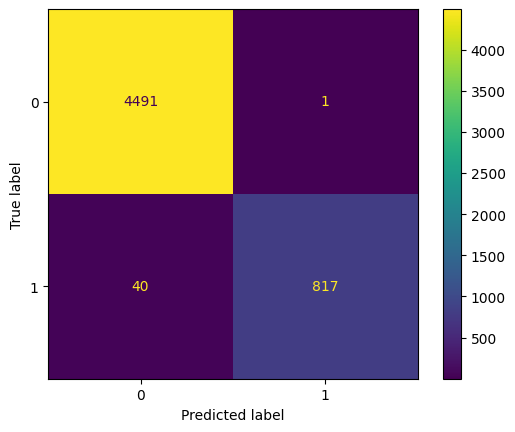

In [150]:
ConfusionMatrixDisplay(confusion_matrix(actual_stockout, pred_stockout)).plot()
plt.show()

In [151]:
acc = accuracy_score(actual_stockout, pred_stockout)
prec = precision_score(actual_stockout, pred_stockout)
rec = recall_score(actual_stockout, pred_stockout)
f1 = f1_score(actual_stockout, pred_stockout)

print("Stockout / Overstock Metrics (Test Set)")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")

Stockout / Overstock Metrics (Test Set)
Accuracy : 0.992
Precision: 0.999
Recall   : 0.953
F1-score : 0.976


In [152]:
# log to json file

data={
    "model":"lstm",
    "metrics" : {
        "mae": mae,
        "rmse": rmse,
        'r2': r2,
        "stockout_accuracy": acc,
        "precision":prec,
        "recall":rec,
        "f1-score":f1
    }
}

with open("../outputs/lstm_performance_metrics.json",'w') as f:
    json.dump(data, f, indent=4)

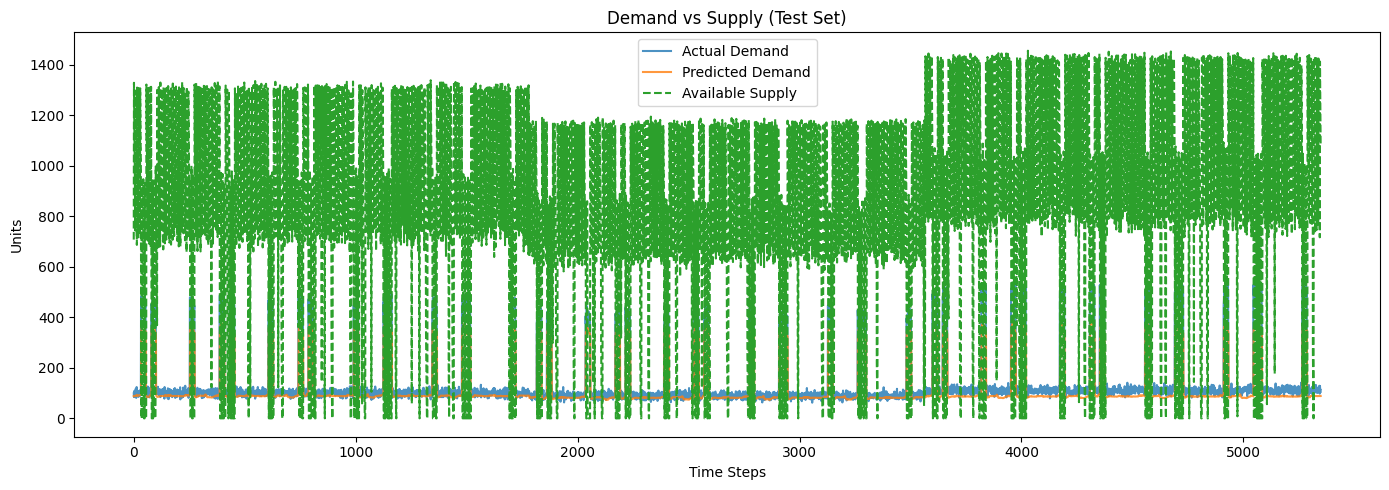

In [153]:
plt.figure(figsize=(14, 5))

plt.plot(y_true, label="Actual Demand", alpha=0.8)
plt.plot(y_pred, label="Predicted Demand", alpha=0.8)
plt.plot(supply_te, label="Available Supply", linestyle="--")

plt.title("Demand vs Supply (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/LSTM/demand_vs_supply.png")
plt.show()


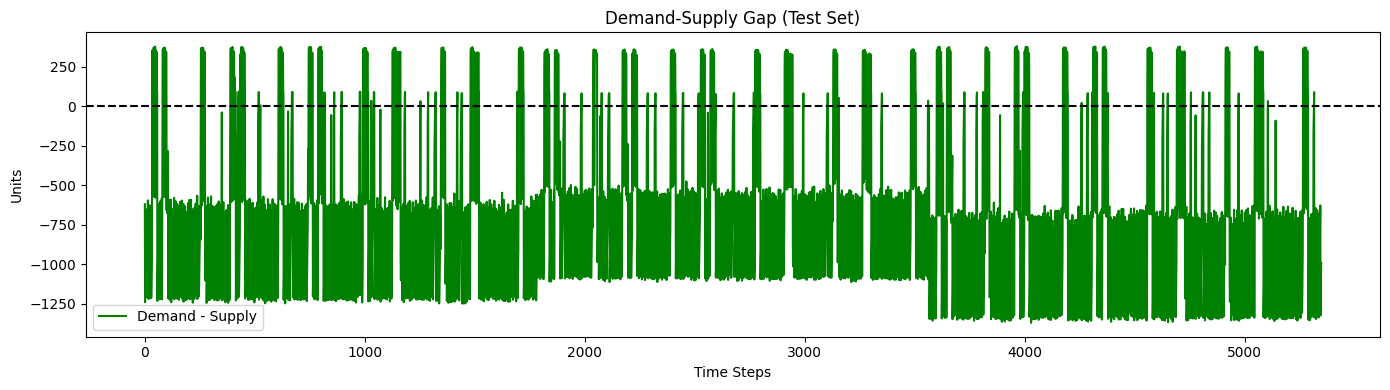

In [154]:
plt.figure(figsize=(14, 4))

plt.plot(gap, color="green", label="Demand - Supply")
plt.axhline(0, linestyle="--", color="black")

plt.title("Demand-Supply Gap (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/LSTM/demand_supply_gap.png")
plt.show()


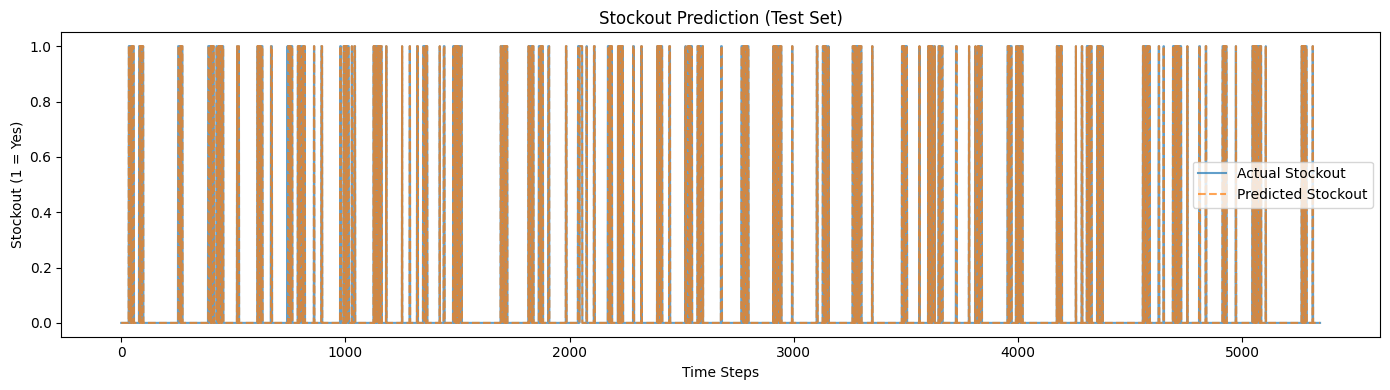

In [155]:
plt.figure(figsize=(14, 4))

plt.plot(actual_stockout, label="Actual Stockout", alpha=0.7)
plt.plot(pred_stockout, label="Predicted Stockout", alpha=0.7, linestyle="--")

plt.title("Stockout Prediction (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Stockout (1 = Yes)")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/LSTM/stockout_prediction.png")
plt.show()


In [156]:
#Doing the same for last 300 points only
y_pred_300=y_pred[-300:]
y_true_300=y_true[-300:]
supply_te_300=supply_te[-300:]

gap_300= y_pred_300.flatten() - supply_te_300.flatten()

In [157]:
mae_300 = mean_absolute_error(y_true_300, y_pred_300)
rmse_300 = np.sqrt(mean_squared_error(y_true_300, y_pred_300))
r2_300 = r2_score(y_true_300, y_pred_300)

print("Demand Forecast Metrics (Test Set)")
print(f"MAE  : {mae_300:.2f}")
print(f"RMSE : {rmse_300:.2f}")
print(f"R²   : {r2_300:.3f}")


Demand Forecast Metrics (Test Set)
MAE  : 48.32
RMSE : 72.47
R²   : 0.770


In [158]:
actual_stockout_300 = (y_true_300.flatten() > supply_te_300.flatten()).astype(int)
pred_stockout_300 = (y_pred_300.flatten() > supply_te_300.flatten()).astype(int)


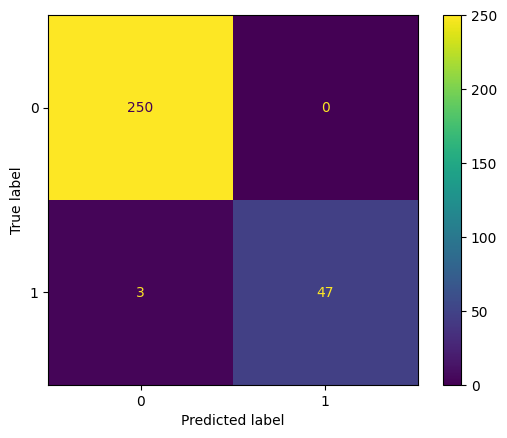

In [159]:
ConfusionMatrixDisplay(confusion_matrix(actual_stockout_300, pred_stockout_300)).plot()
plt.show()

In [160]:
acc_300 = accuracy_score(actual_stockout_300, pred_stockout_300)
prec_300 = precision_score(actual_stockout_300, pred_stockout_300)
rec_300 = recall_score(actual_stockout_300, pred_stockout_300)
f1_300 = f1_score(actual_stockout_300, pred_stockout_300)

print("Stockout / Overstock Metrics (Test Set) - 300 points")
print(f"Accuracy : {acc_300:.3f}")
print(f"Precision: {prec_300:.3f}")
print(f"Recall   : {rec_300:.3f}")
print(f"F1-score : {f1_300:.3f}")

Stockout / Overstock Metrics (Test Set) - 300 points
Accuracy : 0.990
Precision: 1.000
Recall   : 0.940
F1-score : 0.969


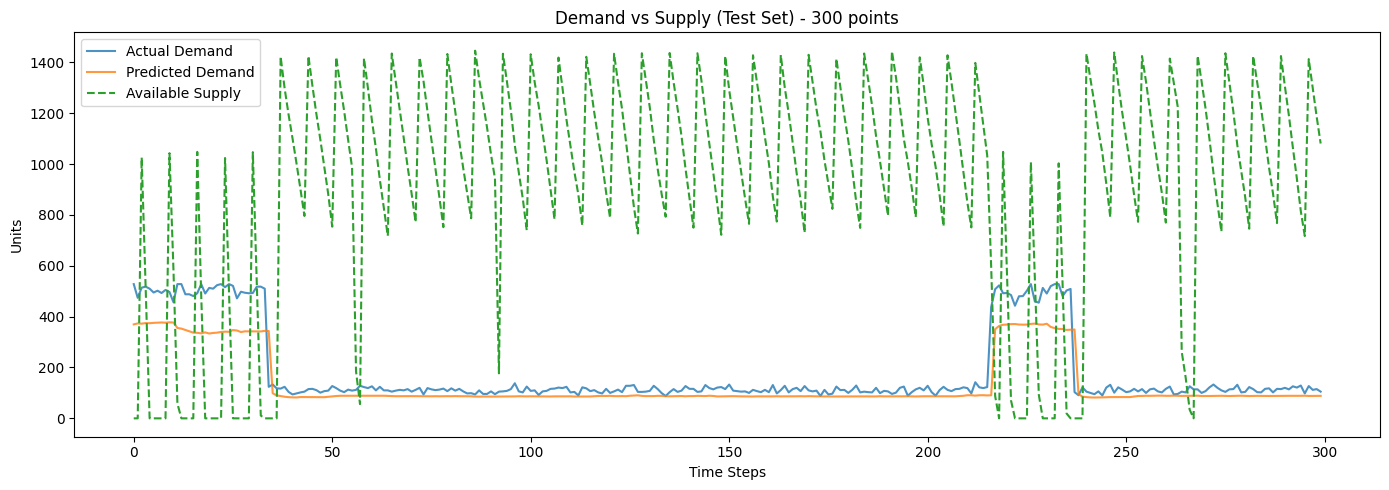

In [161]:
plt.figure(figsize=(14, 5))

plt.plot(y_true_300, label="Actual Demand", alpha=0.8)
plt.plot(y_pred_300, label="Predicted Demand", alpha=0.8)
plt.plot(supply_te_300, label="Available Supply", linestyle="--")

plt.title("Demand vs Supply (Test Set) - 300 points")
plt.xlabel("Time Steps")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/LSTM/demand_vs_supply_300.png")
plt.show()


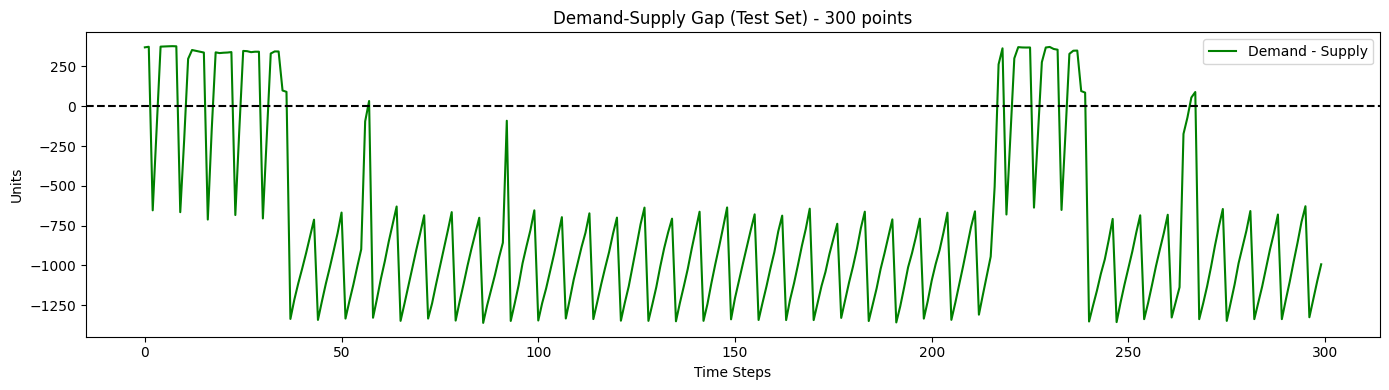

In [162]:
plt.figure(figsize=(14, 4))

plt.plot(gap_300, color="green", label="Demand - Supply")
plt.axhline(0, linestyle="--", color="black")

plt.title("Demand-Supply Gap (Test Set) - 300 points")
plt.xlabel("Time Steps")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/LSTM/demand_supply_gap_300.png")
plt.show()


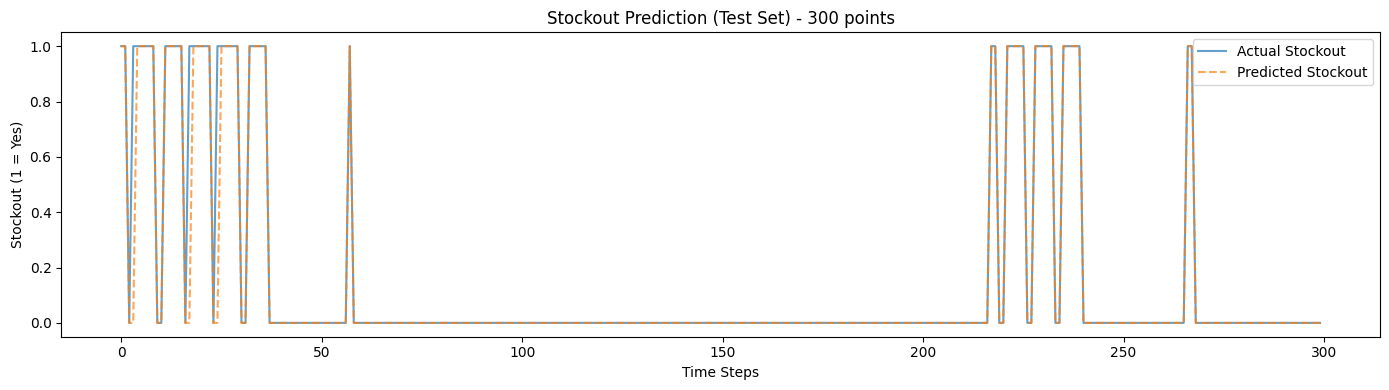

In [163]:
plt.figure(figsize=(14, 4))

plt.plot(actual_stockout_300, label="Actual Stockout", alpha=0.7)
plt.plot(pred_stockout_300, label="Predicted Stockout", alpha=0.7, linestyle="--")

plt.title("Stockout Prediction (Test Set) - 300 points")
plt.xlabel("Time Steps")
plt.ylabel("Stockout (1 = Yes)")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/LSTM/stockout_prediction_300.png")
plt.show()
